In [1]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from confirm.mini_imprint import batch, grid, adagrid, driver, db

In [2]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = batch.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

## Calculate Type I Error

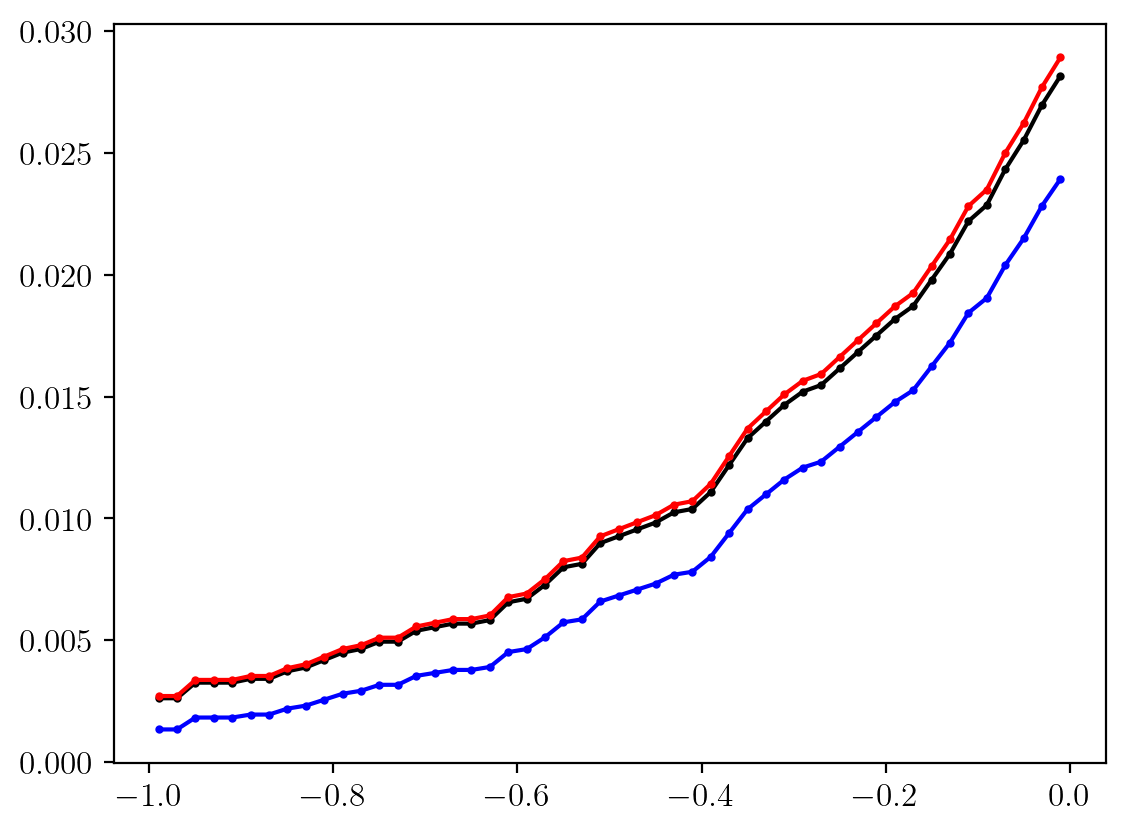

In [3]:
K = 8192
model = ZTest1D(seed=0, max_K=K)

N = 100
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
g = grid.init_grid(theta, radii, K).add_null_hypo(0).prune()

# TODO: is there any problem from using the same seed with the bootstrap
# indices and the simulations?
dd = driver.Driver(model)

# lam = -1.96 because we negated the statistics so we can do a less thanj
# comparison.
rej_df = dd.rej(g.df, -1.96)

plt.plot(g.df["theta0"], rej_df["TI_sum"] / rej_df["K"], "b-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_cp_bound"], "k-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_bound"], "r-o", markersize=2)
plt.show()

## Adagrid Tuning

In [73]:
init_K = 2048
n_K_double = 4
model = ZTest1D(seed=1, max_K=init_K * 2**n_K_double)


N = 4
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
g = grid.init_grid(theta, radii, init_K).add_null_hypo(0).prune()

nB = 6
grid_target = 0.001
bias_target = 0.001
iter_size = 20
max_iter = 100
ada_driver = adagrid.AdagridDriver(model, init_K, n_K_double, nB, bootstrap_seed=2)

In [74]:
ada = adagrid.Adagrid(
    ada_driver, g, db.DuckDBTiles, grid_target, bias_target, iter_size
)

In [75]:
from rich import print as rprint

reports = []
for ada_iter in range(1, max_iter):
    done, report = ada.step(ada_iter)
    rprint(report)
    reports.append(report)
    if done:
        break

{
    'i': 1,
    'bias': '0.00008',
    'std_tie': '0.00187',
    'spread_tie': '0.0063',
    'grid_cost': '0.0127',
    'n_refine': 1,
    'n_deepen': 1,
    'n_finished': 0,
    'n_impossible': 2
}

{
    'i': 2,
    'bias': '0.00130',
    'std_tie': '0.00127',
    'spread_tie': '0.0034',
    'grid_cost': '0.0073',
    'n_refine': 1,
    'n_deepen': 4,
    'n_finished': 0,
    'n_impossible': 3
}

{
    'i': 3,
    'bias': '0.00057',
    'std_tie': '0.00276',
    'spread_tie': '0.0078',
    'grid_cost': '0.0039',
    'n_refine': 1,
    'n_deepen': 7,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 4,
    'bias': '0.00033',
    'std_tie': '0.00308',
    'spread_tie': '0.0083',
    'grid_cost': '0.0020',
    'n_refine': 2,
    'n_deepen': 9,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 5,
    'bias': '0.00081',
    'std_tie': '0.00256',
    'spread_tie': '0.0068',
    'grid_cost': '0.0010',
    'n_refine': 5,
    'n_deepen': 12,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 6,
    'bias': '0.00187',
    'std_tie': '0.00191',
    'spread_tie': '0.0049',
    'grid_cost': '0.0005',
    'n_refine': 0,
    'n_deepen': 20,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 7,
    'bias': '0.00020',
    'std_tie': '0.00149',
    'spread_tie': '0.0042',
    'grid_cost': '0.0005',
    'n_refine': 6,
    'n_deepen': 14,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 8,
    'bias': '-0.00039',
    'std_tie': '0.00123',
    'spread_tie': '0.0042',
    'grid_cost': '0.0005',
    'n_refine': 0,
    'n_deepen': 20,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 9,
    'bias': '0.00056',
    'std_tie': '0.00107',
    'spread_tie': '0.0029',
    'grid_cost': '0.0005',
    'n_refine': 0,
    'n_deepen': 20,
    'n_finished': 0,
    'n_impossible': 0
}

{
    'i': 10,
    'bias': '0.00017',
    'std_tie': '0.00063',
    'spread_tie': '0.0020',
    'grid_cost': '0.0005',
    'n_refine': 0,
    'n_deepen': 2,
    'n_finished': 18,
    'n_impossible': 0
}

In [79]:
evolution["bias"].astype(float)

0    0.00008
1    0.00130
2    0.00057
3    0.00033
4    0.00081
5    0.00187
6    0.00020
7   -0.00039
8    0.00056
9    0.00017
Name: bias, dtype: float64

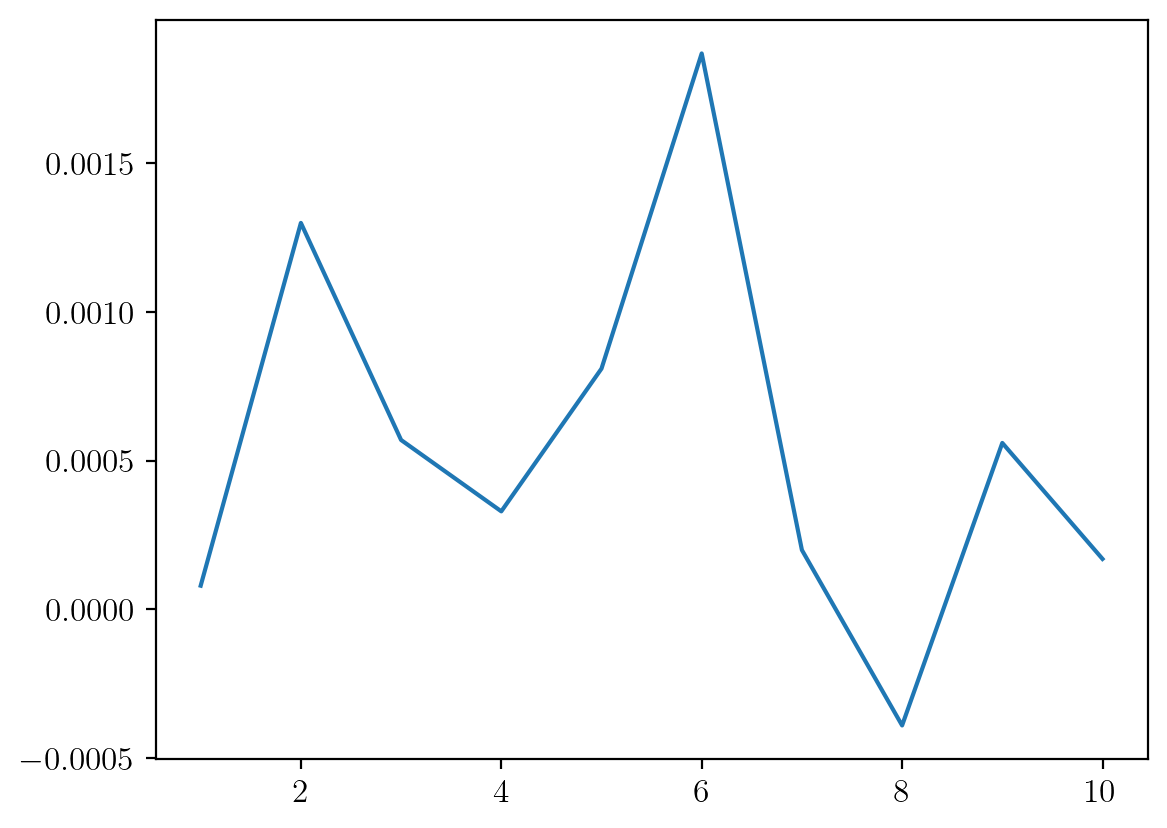

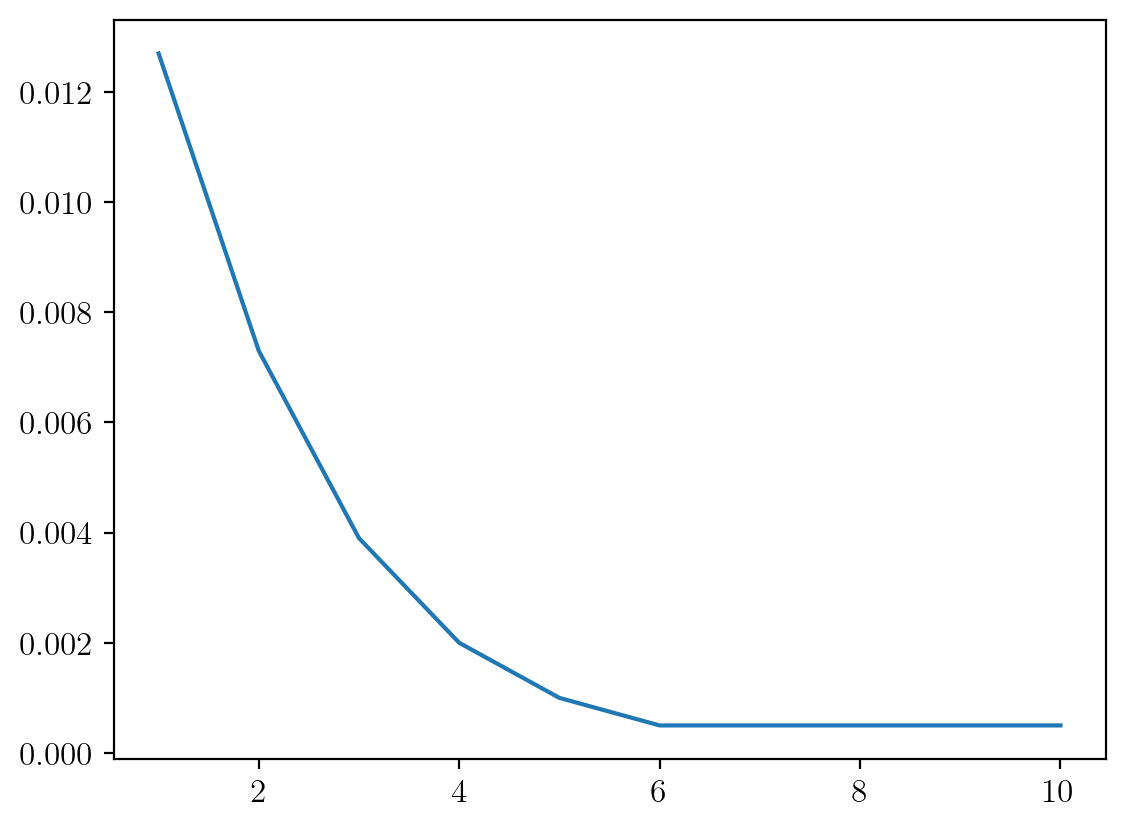

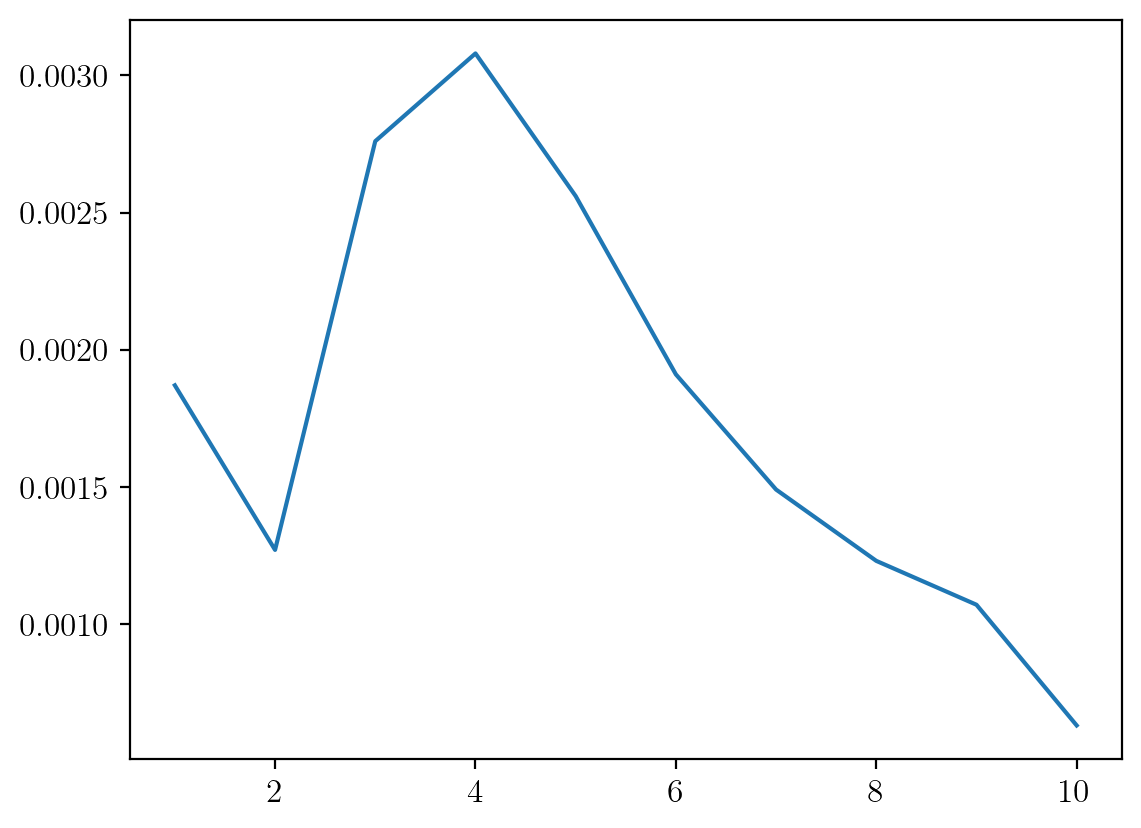

In [82]:
evolution = pd.DataFrame(reports)
plt.plot(evolution["i"], evolution["bias"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["grid_cost"].astype(float))
plt.show()
plt.plot(evolution["i"], evolution["std_tie"].astype(float))
plt.show()

In [69]:
all = ada.tiledb.get_all()
all = all.loc[all["active"]]
all.nsmallest(10, "orderer")

,id,K,theta0,radii0,parent_idx,birthday,active,locked,eligible,null_truth0,alpha0,grid_cost,impossible,orderer,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_min_lams,twb_mean_lams,twb_max_lams
163,163,32768,-0.007812,0.007812,143,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
164,164,32768,-0.007812,0.007812,144,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
165,165,32768,-0.007812,0.007812,145,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
166,166,32768,-0.007812,0.007812,146,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
167,167,32768,-0.007812,0.007812,147,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
168,168,32768,-0.007812,0.007812,148,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
169,169,32768,-0.007812,0.007812,149,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
170,170,32768,-0.007812,0.007812,150,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
171,171,32768,-0.007812,0.007812,151,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292
172,172,32768,-0.007812,0.007812,152,9,True,False,False,True,0.024474,0.000526,False,-2.009587,-1.962952,-1.978474,-1.940708,-1.968792,-1.968931,-1.975968,-1.940433,-1.987798,-1.990071,-2.009587,-1.969292,-1.973393,-1.98689,-2.009587,-1.986172,-1.969292


In [70]:
all["lams"].min()

-1.962951898574829

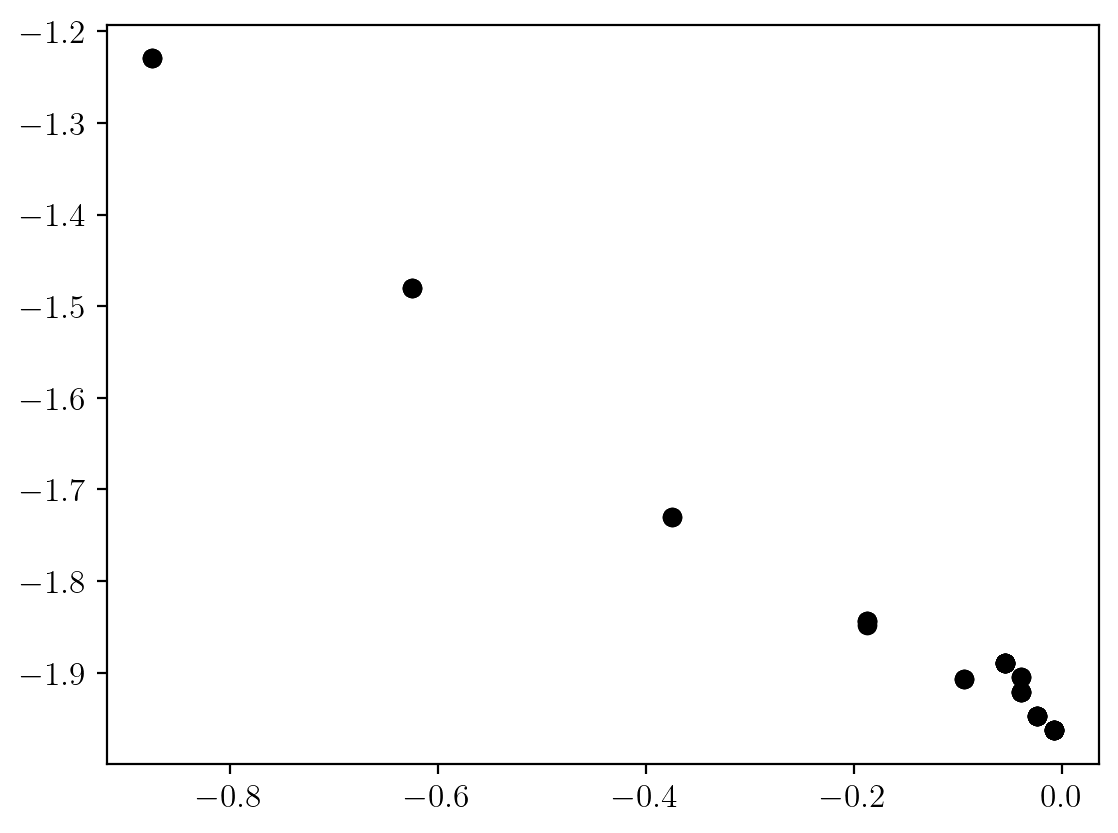

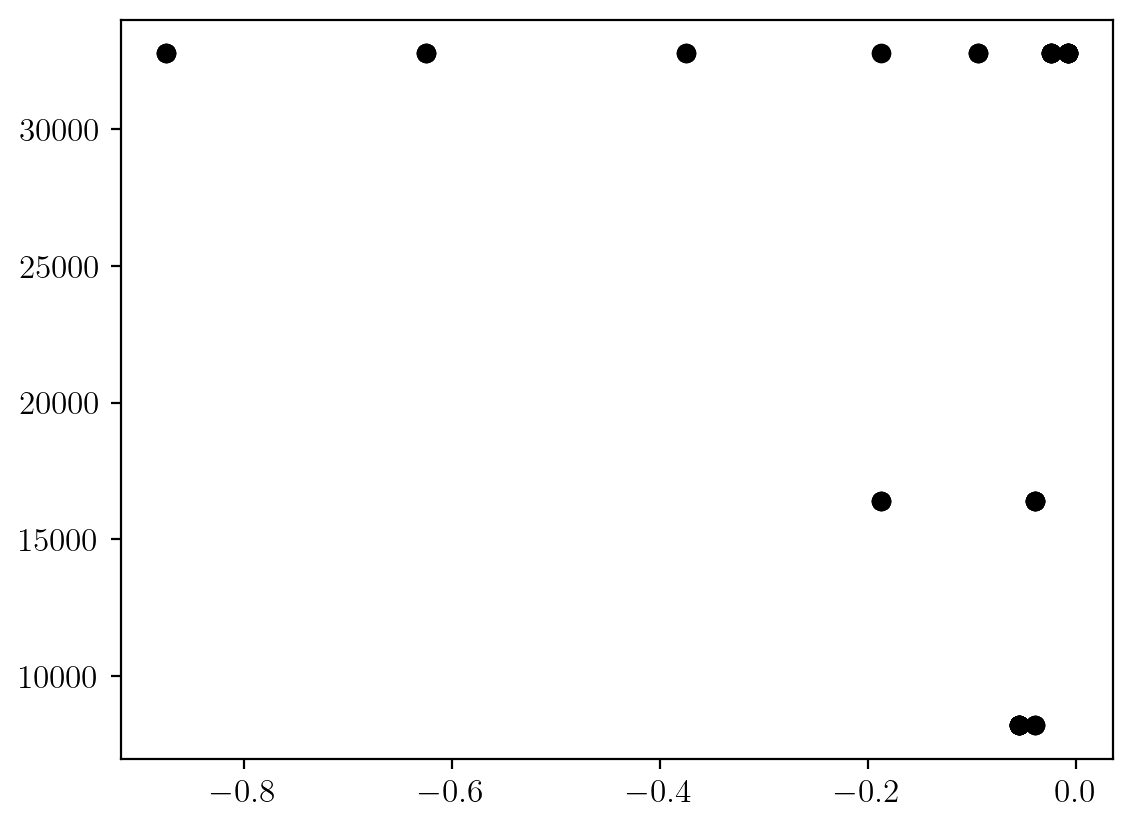

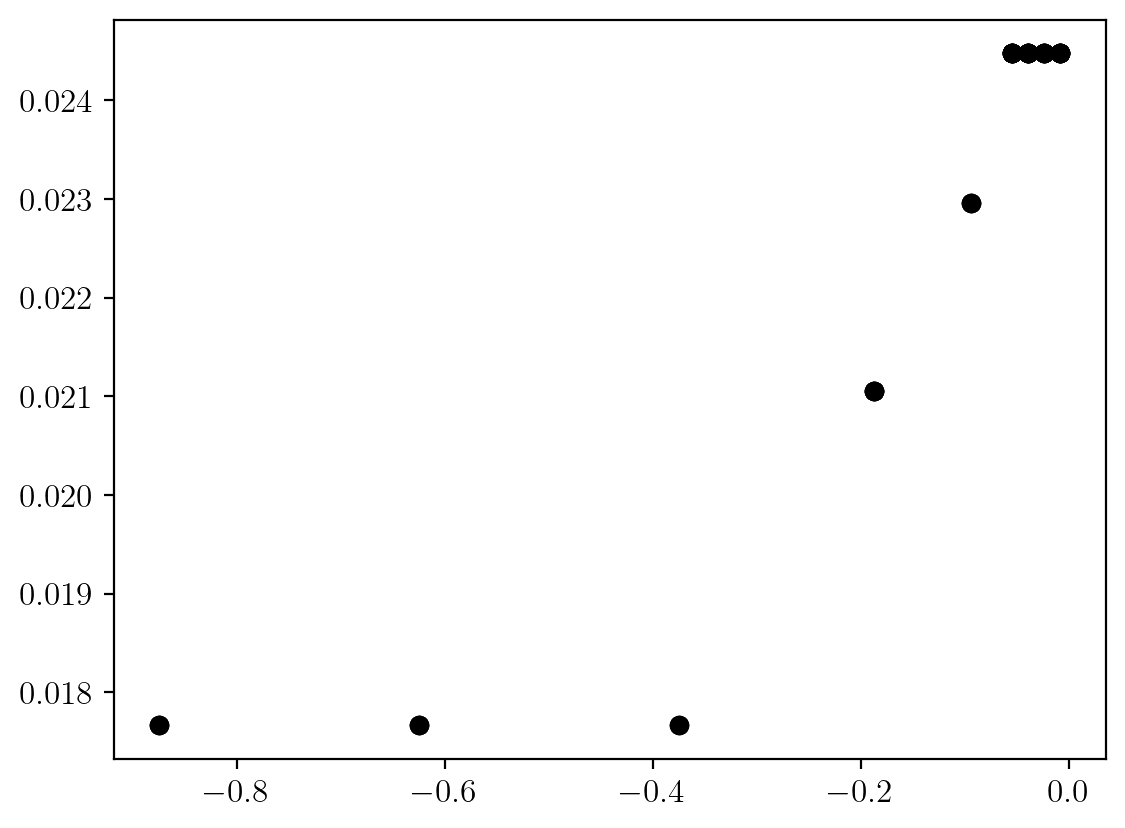

In [71]:
plt.plot(all["theta0"], all["lams"], "ko")
plt.show()
plt.plot(all["theta0"], all["K"], "ko")
plt.show()
plt.plot(all["theta0"], all["alpha0"], "ko")
plt.show()